## Уравнение переноса


Цыбулин Иван ([tsybulin@crec.mipt.ru](mailto:tsybulin@crec.mipt.ru))

### Линейное уравнение переноса

Уравнение переноса &mdash; простейшее уравнение гиперболического типа. Неизвестной является функция $u(t, x)$.

$$\begin{aligned}
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = f(t, x), \qquad c > 0, \; c = \operatorname{const}
\end{aligned}\\
u\big|_{t=0} = u_0(x)
$$

Физический смысл решения &mdash; перенос начального профиля решения с постоянной скоростью $c$ вправо:
$$
u(t, x) = u_0(x - c t)
$$

Описывает, например, перенос загрязнения в равномерном течении жидкости или динамику плотности машин на дороге.

### Сетка

При переходе к уравнениям в частных производных сетка становится многомерной:

<img src="grid.png" style="height:400px">

Верхний индекс $n$ означает номер слоя по времени, а нижний индекс $m$ означает номер узла по пространству. Также шаг по времени принято обозначать $\tau$, а по пространственной переменной &mdash; $h$.

### Шаблон разностной схемы

Пусть для вычисления $u^{n+1}_m$ требуются значения сеточной функции $u$ в нескольких узлах. Тогда вместе с узлом $(n+1, m)$ они образуют *шаблон разностной схемы*. Шаблон удобно изображать графически, например, ниже приведен шаблон схемы «явный левый уголок».

<img src="stencil.png" style="height:200px">

Некоторые выводы о разностной схеме можно сделать изучив только ее шаблон.

### Условие Куранта-Фридрихса-Леви

Все уравнения гиперболического типа имеют характеристики. Для уравнения переноса
$$
u_t + c u_x = 0
$$
характеристиками будут линии
$$
dx - c dt = 0 \Leftrightarrow x - ct = \operatorname{const}
$$
Условие Куранта-Фридрихса-Леви запрещает схемам быть устойчивыми, если характеристика, выпущенная из расчетного узла выходит за пределы шаблона разностной схемы.

<img src="cfl.png" style="height:200px">

### Некоторые схемы для уравнения переноса

* Явный левый уголок
$$
\frac{u^{n+1}_m - u^n_m}{\tau} + c \frac{u^n_m - u^n_{m-1}}{h} = f^n_m
$$

* Явный правый уголок
$$
\frac{u^{n+1}_m - u^n_m}{\tau} + c \frac{u^n_{m+1} - u^n_m}{h} = f^n_m
$$

* Схема с центральной разностью
$$
\frac{u^{n+1}_m - u^n_m}{\tau} + c \frac{u^n_{m+1} - u^n_{m-1}}{2h} = f^n_m
$$

* Схема Лакса
$$
\frac{u^{n+1}_m - \frac{1}{2}\left(u^n_{m-1} + u^n_{m+1}\right)}{\tau} + c \frac{u^n_{m+1} - u^n_{m-1}}{2h} = f^n_m
$$

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def solve_advection(u0, g, method, M=200, courant=0.5, verbose=False):
    X = np.linspace(0, 1, M+1); h = X[1] - X[0]
    if verbose: print('Метод:', method.name, ', число Куранта cт/h =', courant)
    tau = courant * h   # Скорость с = 1
    u = u0(X)           # Заполняем начальное условие
    t = 0; tmax = 0.6; steps = 0
    while t < tmax:
        if t + tau > tmax: tau = tmax - t + 1e-14
        unext = np.empty_like(u)
        unext[0] = g(t+tau) # Используем в левом узле гран условия
        # В остальных точках считаем по заданной схеме
        unext[1:] = method(u, tau, h)
        u = unext       # Переходим на новый слой по времени
        t += tau; steps += 1
    if verbose: print('t =', t, ', сделано', steps, 'шагов')
    return X, u

In [38]:
def upwind(u, tau, h):
    sigma = tau/h
    return sigma*u[:-1] + (1-sigma)*u[1:]
upwind.name = 'Левый уголок'

def central(u, tau, h):
    sigma = tau/h
    return np.append(
        u[1:-1] - sigma/2 * (u[2:] - u[:-2]),
        [sigma*u[-2] + (1-sigma)*u[-1]]) # Уголок в самой правой точке
central.name = 'Центральная разность'

def lax(u, tau, h):
    sigma = tau/h
    return np.append(
        0.5*(1+sigma)*u[:-2] + 0.5*(1-sigma)*u[2:],
        [sigma*u[-2] + (1-sigma)*u[-1]]) # Уголок в самой правой точке
lax.name = 'Схема Лакса'

In [39]:
def step(x): # Начальное условие - ступенька
    return np.double(x < 0.2)

def g(t): # Левое граничное условие
    return 1.0

Метод: Левый уголок , число Куранта cт/h = 0.5
t = 0.6 , сделано 241 шагов


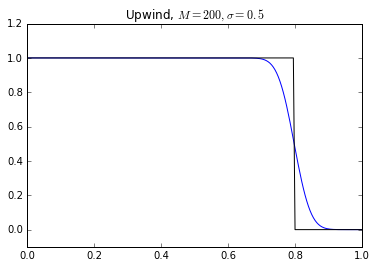

In [71]:
X, u = solve_advection(step, g, upwind, courant=0.5, verbose=True)
plt.plot(X, u)
plt.plot(X, step(X - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.2)
plt.title('Upwind, $M = 200, \sigma=0.5$'); plt.show()

Метод: Центральная разность , число Куранта cт/h = 0.5
t = 0.6 , сделано 241 шагов


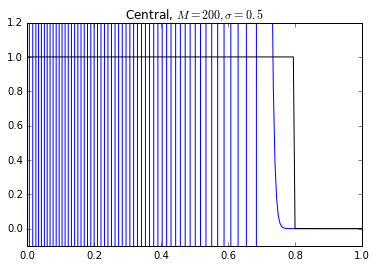

In [72]:
X, u = solve_advection(step, g, central, courant=0.5, verbose=True)
plt.plot(X, u)
plt.plot(X, step(X - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.2)
plt.title('Central, $M = 200, \sigma=0.5$'); plt.show()

Метод: Центральная разность , число Куранта cт/h = 0.01
t = 0.6 , сделано 12001 шагов


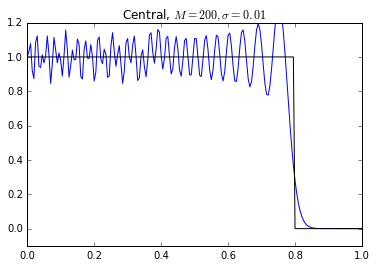

In [73]:
# Схему с центральной разностью можно считать устойчивой при
# выполнении условия т=O(h^2), то есть при малых числах Куранта
X, u = solve_advection(step, g, central, courant=0.01, verbose=True)
plt.plot(X, u)
plt.plot(X, step(X - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.2)
plt.title('Central, $M = 200, \sigma=0.01$'); plt.show()

Метод: Схема Лакса , число Куранта cт/h = 0.5
t = 0.6 , сделано 241 шагов


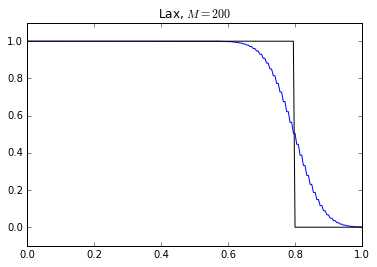

In [74]:
X, u = solve_advection(step, g, lax, courant=0.5, verbose=True)
plt.plot(X, u)
plt.plot(X, step(X - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.1)
plt.title('Lax, $M = 200$'); plt.show()

Схема Лакса обладает условной аппроксимацией. Ее ошибка аппроксимации имеет вид $O\left(\tau, \frac{h^2}{\tau}\right)$. Если $\tau = O(h)$, то схема ведет себя как схема первого порядка по времени, но вот если взять $\tau = O(h^2)$, то численное решение будет сходиться к решению другой задачи!

Напротив, схема «явный левый уголок» аппроксимирует уравнение с первым порядком по времени и пространству безусловно. 

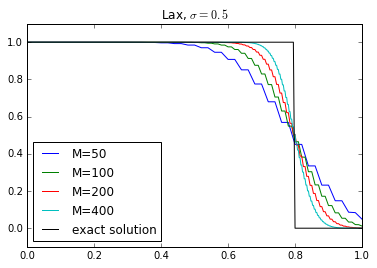

In [75]:
X1, u1 = solve_advection(step, g, lax, M= 50, courant=0.5)
X2, u2 = solve_advection(step, g, lax, M=100, courant=0.5)
X3, u3 = solve_advection(step, g, lax, M=200, courant=0.5)
X4, u4 = solve_advection(step, g, lax, M=400, courant=0.5)
plt.plot(X1, u1, label='M=50'); plt.plot(X2, u2, label='M=100');
plt.plot(X3, u3, label='M=200'); plt.plot(X4, u4, label='M=400')
plt.plot(X3, step(X3 - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.1); plt.legend(loc='lower left')
plt.title('Lax, $\sigma = 0.5$'); plt.show()

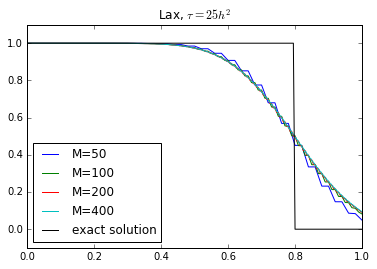

In [76]:
X1, u1 = solve_advection(step, g, lax, M= 50, courant=0.5)
X2, u2 = solve_advection(step, g, lax, M=100, courant=0.25)
X3, u3 = solve_advection(step, g, lax, M=200, courant=0.125)
X4, u4 = solve_advection(step, g, lax, M=400, courant=0.0625)
plt.plot(X1, u1, label='M=50'); plt.plot(X2, u2, label='M=100');
plt.plot(X3, u3, label='M=200'); plt.plot(X4, u4, label='M=400')
plt.plot(X3, step(X3 - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.1); plt.legend(loc='lower left')
plt.title(r'Lax, $\tau = 25h^2$'); plt.show()

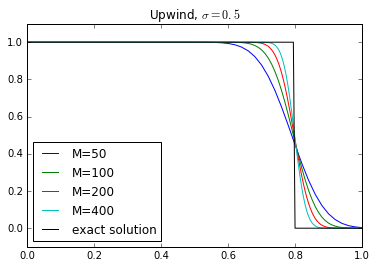

In [61]:
X1, u1 = solve_advection(step, g, upwind, M= 50, courant=0.5)
X2, u2 = solve_advection(step, g, upwind, M=100, courant=0.5)
X3, u3 = solve_advection(step, g, upwind, M=200, courant=0.5)
X4, u4 = solve_advection(step, g, upwind, M=400, courant=0.5)
plt.plot(X1, u1, label='M=50'); plt.plot(X2, u2, label='M=100');
plt.plot(X3, u3, label='M=200'); plt.plot(X4, u4, label='M=400')
plt.plot(X3, step(X3 - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.1); plt.legend(loc='lower left')
plt.title('Upwind, $\sigma = 0.5$'); plt.show()

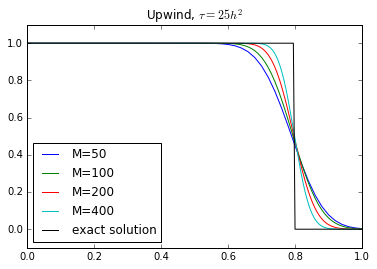

In [62]:
X1, u1 = solve_advection(step, g, upwind, M= 50, courant=0.5)
X2, u2 = solve_advection(step, g, upwind, M=100, courant=0.25)
X3, u3 = solve_advection(step, g, upwind, M=200, courant=0.125)
X4, u4 = solve_advection(step, g, upwind, M=400, courant=0.0625)
plt.plot(X1, u1, label='M=50'); plt.plot(X2, u2, label='M=100');
plt.plot(X3, u3, label='M=200'); plt.plot(X4, u4, label='M=400')
plt.plot(X3, step(X3 - 0.6), 'k', label='exact solution')
plt.ylim(-0.1, 1.1); plt.legend(loc='lower left')
plt.title(r'Upwind, $\tau = 25h^2$'); plt.show()

### Устойчивость

Устойчивость разностной задачи для уравнений в частных производных определяется аналогично устойчивости для обыкновенных дифференциальных уравнейний. 

Пусть $u^n_m$ &mdash; решение разностной задачи с начальными условиями $\psi_m$, граничными условиями $\beta^n$ и правой частью $f^n_m$. Разностная задача называется устойчивой, если при небольших возмущениях $\psi \to \tilde \psi, \beta \to \tilde \beta$ и $f \to \tilde f$ разностная задача продолжает иметь единственное решение $\tilde{u}^n_m$, причем в некоторой норме выполнено
$$
\|\tilde u - u\| \leqslant C \left(\|\tilde \psi - \psi\| + \|\tilde \beta - \beta\| + \|\tilde f - f\|\right),
$$
где константа $C$ не зависит от сеточных параметров $\tau$ и $h$. Для линейных разностных задач это требование эквивалентно выполнению 
$$
\|u\| \leqslant C \left(\|\psi\| + \|\beta\| + \|f\|\right).
$$

### Доказательство устойчивости по определению
Возьмем следующую задачу (уравнение переноса, схема Лакса внутри области, на правой границе - уголок)
* Начальные условия (слой $n = 0$)
$$u^0_m = \psi_m, \qquad m = 0, 1, \dots, M$$
* Левое граничное условие (узел $m = 0$)
$$u^{n+1}_0 = \beta^{n+1}$$
* Схема в области (узлы $m = 1, 2, \dots, M-1$)
$$\frac{u^{n+1}_m - \frac{1}{2}(u^n_{m-1} + u^n_{m+1})}{\tau} + 
c \frac{u^n_{m+1} - u^n_{m-1}}{2h} = f^n_m$$
* Схема у правой границы (узел $m = M$)
$$\frac{u^{n+1}_M - u^n_M}{\tau} + 
c \frac{u^n_M - u^n_{M-1}}{h} = f^n_M$$

Разрешим уравнения относительно слоя $u^{n+1}$ (введем обозначение $\sigma = \frac{c\tau}{h}$):
$$
\begin{aligned}
u^{n+1}_0 &= \beta^{n+1}\\
u^{n+1}_m &= \frac{1+\sigma}{2} u^n_{m-1} + \frac{1-\sigma}{2} u^n_{m+1} + \tau f^n_m, \quad m = 1, 2, \dots, M-1\\
u^{n+1}_M &= \sigma u^n_{M-1} + (1-\sigma) u^n_M + \tau f^n_M
\end{aligned}
$$

Возьмем следующие нормы:
$$
\|u^n\| = \max_{m=0,1,\dots,M} |u^n_m|, \qquad \|u\| = \max_{n=0,1,\dots,N} \|u^n\|
$$

Оценим $\|u^{n+1}\|$:
$$
|u^{n+1}_0| \leqslant |\beta^{n+1}|\\
|u^{n+1}_m| \leqslant \left|\frac{1+\sigma}{2}\right| |u^n_{m-1}| + \left|\frac{1-\sigma}{2}\right| |u^n_{m+1}| + \tau |f^n_m|, \quad m = 1, 2, \dots, M-1\\
|u^{n+1}_M| \leqslant |\sigma| |u^n_{M-1}| + |1-\sigma| |u^n_M| + \tau |f^n_M|
$$
Учтем, что $|u^n_m| \leqslant \|u^n\|, |f^n_m| \leqslant \|f\|$ и $|\beta^{n+1}| \leqslant \|\beta\|$:
$$
|u^{n+1}_0| \leqslant \|\beta\|\\
|u^{n+1}_m| \leqslant \left|\frac{1+\sigma}{2}\right| \|u^n\| + \left|\frac{1-\sigma}{2}\right| \|u^n\| + \tau \|f\|, \quad m = 1, 2, \dots, M-1\\
|u^{n+1}_M| \leqslant |\sigma| \|u^n\| + |1-\sigma| \|u^n\| + \tau \|f\|
$$

Заметим, что при $0 \leqslant \sigma \leqslant 1$ модули с коэффициентов можно снять:
$$
|u^{n+1}_m| \leqslant \left|\frac{1+\sigma}{2}\right| \|u^n\| + \left|\frac{1-\sigma}{2}\right| \|u^n\| + \tau \|f\| = \\ = \frac{1+\sigma}{2} \|u^n\| + \frac{1-\sigma}{2} \|u^n\| + \tau \|f\| = \\ =
\|u^n\| + \tau\|f\|, \qquad m = 1, 2, \dots, M-1
$$
Аналогично на правой границе
$$
|u^{n+1}_M| \leqslant |\sigma| \|u^n\| + |1-\sigma| \|u^n\| + \tau \|f\| = \\ =
\sigma \|u^n\| + (1-\sigma) \|u^n\| + \tau \|f\| = \|u^n\| + \tau \|f\|.
$$
Таким образом, на всем $n+1$ слое по времени выполняется
$$
\color{green}{\|u^{n+1}\| \leqslant \max\left(\|\beta\|, \|u^n\| + \tau \|f\|\right)
\leqslant \max\left(\|\beta\|, \|u^n\|\right) + \tau \|f\|} 
$$

Будем подставлять это условие в себя:
$$
\begin{aligned}
\|u^{n+1}\| &\leqslant \max(\|\beta\|, \|u^n\|) + \tau \|f\| \leqslant \\
&\leqslant \max\big(\|\beta\|, \max(\|\beta\|, \|u^{n-1}\|) + \tau \|f\|\big) + \tau \|f\| \leqslant \\
&\leqslant \max\big(\|\beta\|, \|u^{n-1}\|\big) + 2\tau \|f\| \leqslant \dots \leqslant\\
&\leqslant \max\big(\|\beta\|, \|u^0\|\big) + (n+1)\tau \|f\| \leqslant \\
&\leqslant \max\big(\|\beta\|, \|\psi\|\big) + T \|f\|.
\end{aligned}
$$
Таким образом, мы показали устойчивость задачи по определению:
$$
\|u\| \leqslant \max\big(\|\beta\|, \|\psi\|\big) + T \|f\|.
$$

### Монотонные схемы
Такой способ доказательства устойчивости по определению работает всегда, когда удается записать разностное уравнение в виде
$$
u^{n+1}_m = \sum_{\mu} \alpha_\mu u^n_{m+\mu} + O(\tau),
$$
где все коэффициенты $\alpha_\mu \geqslant 0$. Такие схемы называются монотонными (по Фридрихсу), но известно, что линейные такие схемы для уравнения переноса не могут иметь порядок аппроксимации выше, чем первый.

### Спектральный признак

На практике часто пользуются следующим довольно простым признаком устойчивости. С помощью него можно проверить только устойчивость однородной разностной задачи Коши с постоянными коэффициентами. Для того, чтобы им воспользоваться, необходимо провести ряд упрощений в разностной задаче:
* Избавиться от граничных условий, превратив задачу в задачу Коши (рассматривать уравнение при $m = -\infty,\dots,+\infty$)
* Избавиться от правой части (сделать задачу однородной)
* Сделать все коэффициенты в задаче постоянными &mdash; «заморозить» их.
* Искать решение в специальном виде $u^n_m = \lambda^n e^{i\alpha m}, \quad \alpha \in \mathbb R$

Исследуем схему уголок спектральным признаком. После всех упрощений получаем разностное уравнение
$$
\frac{u^{n+1}_m - u^n_m}{\tau} + c \frac{u^n_m - u^n_{m-1}}{h} = 0
$$
Подставляем $u^n_m = \lambda^n e^{i\alpha m}$:
$$
\frac{\lambda^{n+1} e^{i\alpha m} - \lambda^n e^{i\alpha m}}{\tau} + c \frac{\lambda^n e^{i\alpha m} - \lambda^n e^{i\alpha (m-1)}}{h} = 0
$$
Сократим на $\lambda^n e^{i\alpha m}$:
$$
\frac{\lambda - 1}{\tau} + c \frac{1 - e^{-i\alpha}}{h} = 0
\quad\Rightarrow\quad
\lambda = 1 + \sigma (1 - e^{-i\alpha}), \qquad \sigma \equiv \frac{c\tau}{h}
$$

Величина $\lambda$ показывает как в задаче ведут себя возмущения вида $e^{i\alpha m}$. Если $|\lambda| \leqslant 1$, то возмущения не растут. Если $|\lambda| > 1$, возмущения нарастают экспоненциально и схема неустойчива. Для устойчивости условие $|\lambda| \leqslant 1$ должно быть выполнено при всех $\alpha \in \mathbb R$.

Для схемы левый уголок мы получили выражение
$$
\lambda = 1 + \sigma (1 - e^{-i\alpha}).
$$
Исследовать $\lambda$ удобнее всего графически. При $0 \leqslant \sigma \leqslant 1$ график $\lambda(\alpha)$ имеет вид окружности, касающейся изнутри окружности $|\lambda| = 1$, а при $\sigma \not \in [0, 1]$ график $\lambda(\alpha)$ касается $|\lambda| = 1$ снаружи.

Таким образом, спектральный признак говорит, что при $\sigma \not \in [0, 1]$ схема левый уголок неусточива (условие КФЛ говорит то же самое). При $\sigma \in [0, 1]$ можно гарантировать устойчивость упрощенного уравнения (без граничных условий, без правой части и с замороженным коэффициентом). Как правило, и исходная схема устойчива в этом случае.

Попробуйте решить следующие задачи самостоятельно:
* Покажите, что монотонная схема всегда устойчива по спектральному признаку
* Исследуйте схему с центральной разностью по спектральному признаку. Покажите, что при $\tau = O(h^2)$ для $\lambda$ справделиво
$$
|\lambda| = 1 + O(\tau).
$$
Покажите, что в этом случае величина $\lambda^n$ все же ограничена (если $n \leqslant N = \frac{T}{\tau}$).